In [1]:
using CSV
using DataFrames
using Query
using Statistics
using Random
using PyPlot
using StatsPlots
using GLM
using DecisionTree
using LinearAlgebra
using ScikitLearn
@sk_import linear_model: LogisticRegression


Random.seed!(2);

In [2]:
data = CSV.File("SpeedDatingData.csv") |> DataFrame;

In [99]:
#FILTER DATA SO ALL POINTS HAVE ATTRACTIVENESS
println(size(data))

selected = [:gender, :attr_o, :age_o, :sinc_o, :intel_o, :fun_o, :amb_o, :shar_o, :date, :go_out,:samerace, :age]

for col in selected
    data = data[.!ismissing.(data[!,col]),:];
    end


for col in filter(col -> (col!=:dec_o && col!=:gender && col!=:samerace), selected)
    data[col] = convert.(Float64, data[col]);
    end

for col in filter(col -> (col==:dec_o || col==:gender || col==:samerace), selected)
    data[col] = convert.(Bool, data[col]);
    end


println(size(data))

(6853, 195)
(6853, 195)


In [114]:
## avg_attr_others measures average attractiveness rating given by individual for others
## avg_attr_self measures average attractiveness rating given to individual by others
## count measures number of pairing individual was in
avgs = data |>
    @groupby(_.iid)|>
    @map({iid = key(_), avg_attr_self=mean(_.attr_o)})|>
    DataFrame

df = join(avgs, data, on = :iid)

avgs = df |>
    @groupby(_.pid)|>
    @map({iid = key(_), avg_attr_others=mean(_.attr_o)})|>
    DataFrame

df = join(avgs, df, on= :iid);

count =data |>
    @groupby(_.iid)|>
    @map({iid = key(_),   count = length(_)}) |>
    DataFrame

df = join(count, df, on=:iid);
df[:random] = rand([0,1], size(df, 1));
df[:agediff] = df[:age].-df[:age_o];

In [115]:
# Features we are interested in for initial exploration
selected = [:gender, :avg_attr_self, :avg_attr_others, :dec_o, :samerace, :count, :age, :agediff]
selected = append!(selected, [:fun_o, :amb_o, :shar_o,:sinc_o, :intel_o, :attr_o, :age_o, :date,:go_out,:random])
just_attr = df[selected];

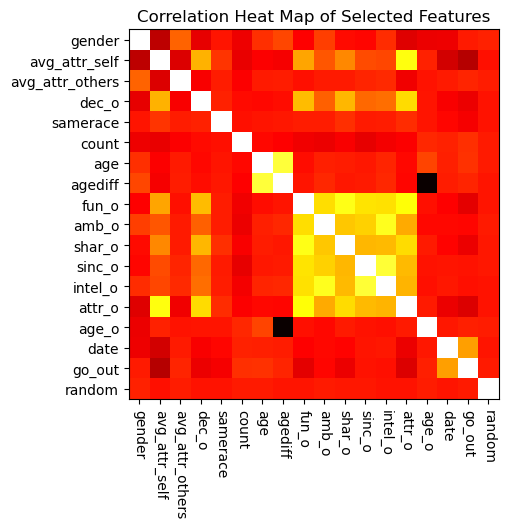

PyObject Text(0.5, 1.0, 'Correlation Heat Map of Selected Features')

In [116]:
corz = cor(Matrix(just_attr))
PyPlot.imshow(corz, cmap="hot",interpolation="nearest" )
xticks(0:size(selected,1)-1, selected, rotation=270)
yticks(0:size(selected,1)-1, selected)
title("Correlation Heat Map of Selected Features")

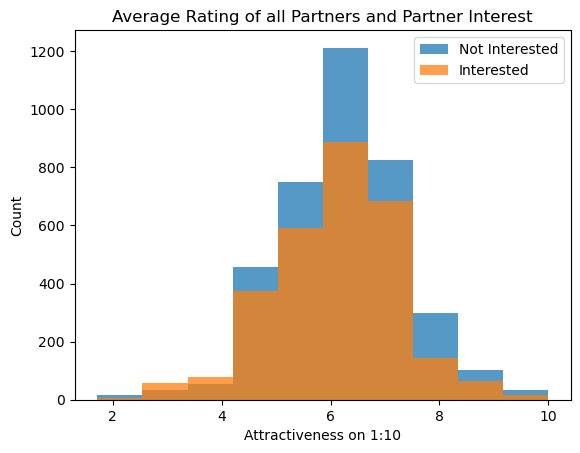

PyObject Text(24.0, 0.5, 'Count')

In [117]:
plt2 = PyPlot.hist(just_attr[:avg_attr_others][just_attr[:dec_o].==0], label="Not Interested", alpha=.75)
plt1 = PyPlot.hist(just_attr[:avg_attr_others][just_attr[:dec_o].==1], label="Interested", alpha=.75)
legend()
title("Average Rating of all Partners and Partner Interest")
xlabel("Attractiveness on 1:10")
ylabel("Count")

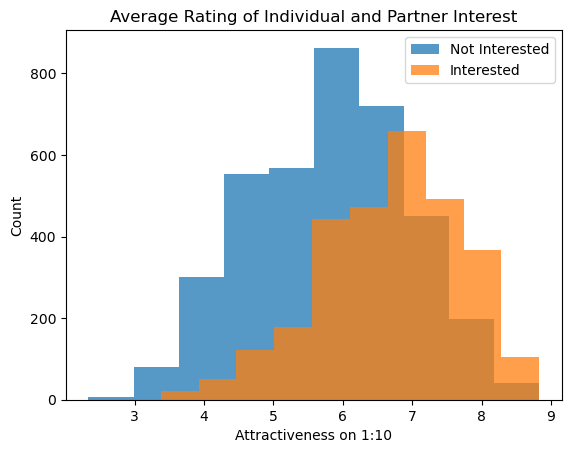

PyObject Text(24.000000000000007, 0.5, 'Count')

In [118]:
plt2 = PyPlot.hist(just_attr[:avg_attr_self][just_attr[:dec_o].==0], label="Not Interested", alpha=.75)
plt1 = PyPlot.hist(just_attr[:avg_attr_self][just_attr[:dec_o].==1], label="Interested", alpha=.75)
legend()
title("Average Rating of Individual and Partner Interest")
xlabel("Attractiveness on 1:10")
ylabel("Count")

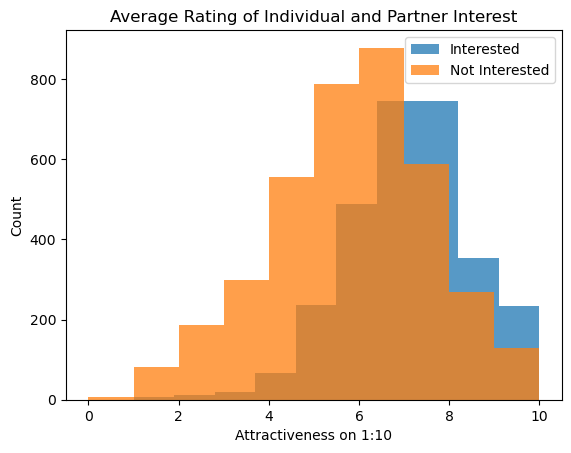

PyObject Text(24.000000000000007, 0.5, 'Count')

In [119]:
plt1 = PyPlot.hist(just_attr[:attr_o][just_attr[:dec_o].==1], label="Interested", alpha=.75)
plt2 = PyPlot.hist(just_attr[:attr_o][just_attr[:dec_o].==0], label="Not Interested", alpha=.75)
legend()
title("Average Rating of Individual and Partner Interest")
xlabel("Attractiveness on 1:10")
ylabel("Count")

In [120]:
# Shuffle Data to ensure fair test/train split
just_attr = just_attr[shuffle(1:end), :]
#Making the split
train_proportion = 0.8
n = size(just_attr, 1)
ntrain = convert(Int, round(train_proportion*n))
println("Size of dataset: ", string(n))
println("Size of training set: ", string(ntrain))
println("Size of testing set: ", string(n-ntrain))


target = just_attr[:dec_o]
X = just_attr[:, filter(col -> (col!=:dec_o), selected)]
#X = just_attr[:, filter(col -> (col==:sinc_o||col==:intel_o||col==:fun_o||col==:amb_o), selected)]
#X = just_attr[:attr_o] .- just_attr[:avg_attr_self]
xtrain = convert(Matrix, X[1:ntrain, :])
xtest = convert(Matrix, X[ntrain+1:end, :]);

Size of dataset: 6688
Size of training set: 5350
Size of testing set: 1338


In [107]:
theme1 = palette([:red, :blue], 7)

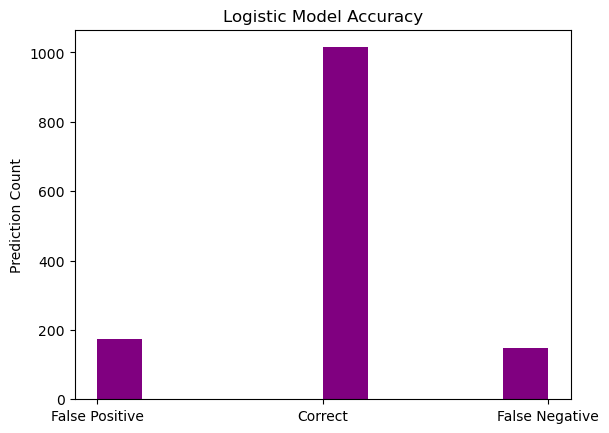

Training Set Error: 0.24728971962616822
Testing Set Error: 0.2414050822122571


C:\Users\Jack\.julia\conda\3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


PyObject Text(0.5, 1.0, 'Logistic Model Accuracy')

In [137]:
using ScikitLearn: fit!, predict
log_reg = fit!(LogisticRegression(penalty="l2", C=10000), xtrain, target[1:ntrain])
#println(predict(log_reg,xtrain))
println("Training Set Error: ",sum(predict(log_reg,xtrain).!=target[1:ntrain])/size(xtrain,1))
println("Testing Set Error: ",sum(predict(log_reg,xtest).!=target[ntrain+1:end])/size(xtest,1))

PyPlot.hist(target[ntrain+1:end].-predict(log_reg,xtest), color="purple")
xticks([-1,0,1], ["False Positive", "Correct", "False Negative"])
ylabel("Prediction Count")
title("Logistic Model Accuracy")

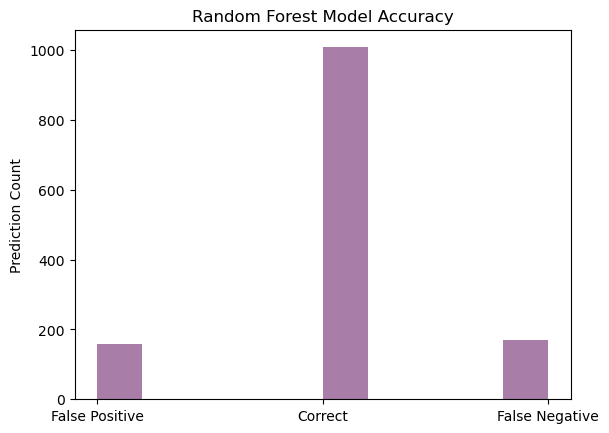

Training Set Error: 0.25327102803738316
Testing Set Error: 0.24663677130044842

PyObject Text(0.5, 1.0, 'Random Forest Model Accuracy')

In [167]:
@sk_import ensemble: RandomForestRegressor

rf = RandomForestRegressor(random_state=69, max_depth=3)

trees = fit!(rf, xtrain, target[1:ntrain])
predicted_train = round.(predict(trees, xtrain))
predicted_test = round.(predict(trees, xtest))

println("Training Set Error: ",sum(predicted_train.!=target[1:ntrain])/size(xtrain,1))
println("Testing Set Error: ",sum(predicted_test.!=target[ntrain+1:end])/size(xtest,1))

PyPlot.hist(target[ntrain+1:end].-predicted_test, color="#a87da8", )
xticks([-1,0,1], ["False Positive", "Correct", "False Negative"])
ylabel("Prediction Count")
title("Random Forest Model Accuracy")

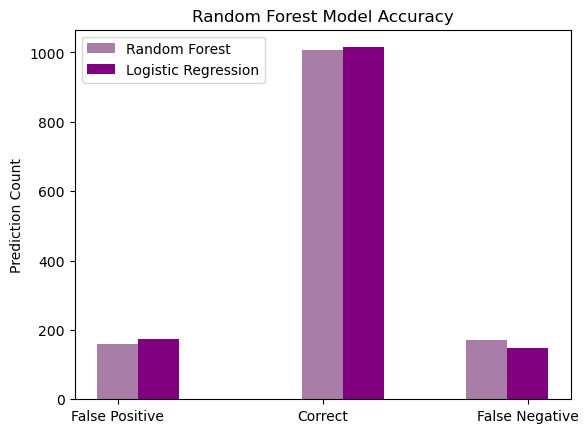

PyObject <matplotlib.legend.Legend object at 0x000000006BF2F940>

In [171]:
PyPlot.hist(target[ntrain+1:end].-predicted_test, color="#a87da8", label="Random Forest", align="left")
PyPlot.hist(target[ntrain+1:end].-predict(log_reg,xtest), color="purple" , label="Logistic Regression", align="right")

xticks([-1,0,1], ["False Positive", "Correct", "False Negative"])
ylabel("Prediction Count")
title("Random Forest Model Accuracy")
legend()

In [139]:
@sk_import inspection: permutation_importance
pimp_tree = permutation_importance(trees, xtrain, target[1:ntrain])["importances_mean"]
pimp_log = permutation_importance(log_reg, xtrain, target[1:ntrain])["importances_mean"]
imp_tree = trees.feature_importances_

imps = DataFrame(hcat(filter(col -> (col!=:dec_o), selected),pimp_log, pimp_tree, imp_tree,))
names!(imps, [:col_nm,:logmodel, :permut_tree, :tree])

17×4 DataFrame
│ Row │ col_nm          │ logmodel     │ permut_tree │ tree        │
│     │ Any             │ Any          │ Any         │ Any         │
├─────┼─────────────────┼──────────────┼─────────────┼─────────────┤
│ 1   │ gender          │ 0.00149533   │ 0.000162948 │ 0.000338331 │
│ 2   │ avg_attr_self   │ 0.0154393    │ 0.0113716   │ 0.0301466   │
│ 3   │ avg_attr_others │ 0.000261682  │ 0.0         │ 0.0         │
│ 4   │ samerace        │ -0.00011215  │ 0.0         │ 0.0         │
│ 5   │ count           │ 0.00269159   │ 0.000107509 │ 0.000376079 │
│ 6   │ age             │ 0.000411215  │ 6.01571e-5  │ 0.000163883 │
│ 7   │ agediff         │ -3.73832e-5  │ 0.0         │ 0.0         │
│ 8   │ fun_o           │ 0.0263178    │ 0.00742689  │ 0.0209803   │
│ 9   │ amb_o           │ 0.00519626   │ 0.0         │ 0.0         │
│ 10  │ shar_o          │ 0.0361495    │ 0.0764051   │ 0.148844    │
│ 11  │ sinc_o          │ 0.00198131   │ 0.0         │ 0.0         │
│ 12  │ intel_o         │ -0.000373832 │ 0.0         │ 0.0         │
│ 13  │ attr_o          │ 0.0855701    │ 0.282347    │ 0.799035    │
│ 14  │ age_o           │ 0.000785047  │ 0.0         │ 0.0         │
│ 15  │ date            │ -0.000373832 │ 0.0         │ 0.0         │
│ 16  │ go_out          │ -0.000598131 │ 4.41996e-5  │ 0.000116477 │
│ 17  │ random          │ -0.000523364 │ 0.0         │ 0.0         │

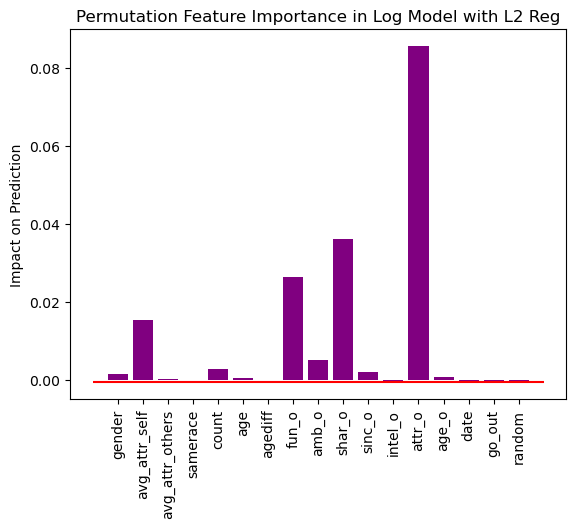

PyObject Text(24.000000000000007, 0.5, 'Impact on Prediction')

In [140]:
#Feature Importance in Log Model with L2 Reg

PyPlot.bar(imps[:col_nm], imps[:logmodel], color="purple")
xticks(0:size(imps[:col_nm],1)-1, imps[:col_nm], rotation=90)
title("Permutation Feature Importance in Log Model with L2 Reg")
PyPlot.hlines(imps[:logmodel][17], -1, 17, color="red")
ylabel("Impact on Prediction")

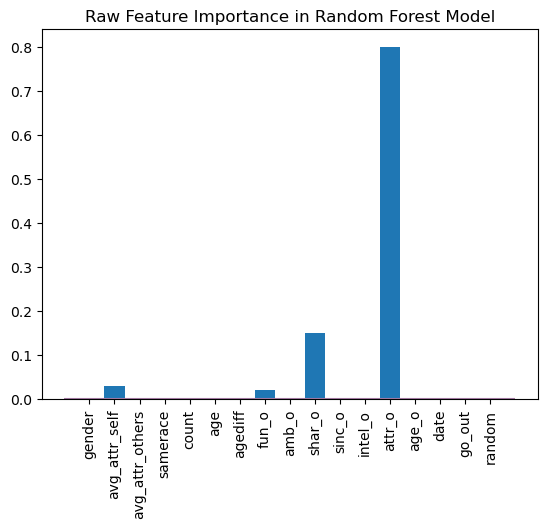

PyObject <matplotlib.collections.LineCollection object at 0x0000000063E766A0>

In [125]:
#Raw Feature Importance in Decision Tree Model

PyPlot.bar(imps[:col_nm], imps[:tree])
xticks(0:size(imps[:col_nm],1)-1, imps[:col_nm], rotation=90)
title("Raw Feature Importance in Random Forest Model")
PyPlot.hlines(imps[:tree][17], -1, 17, color="#a87da8")

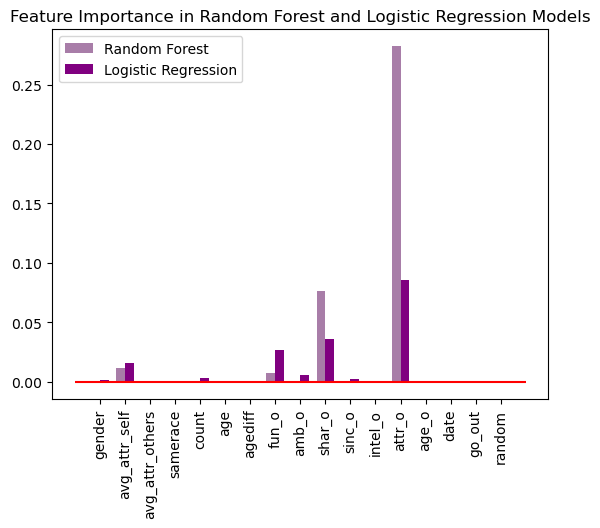

PyObject <matplotlib.collections.LineCollection object at 0x000000006BBC42E0>

In [166]:
#Permutation Feature Importance in Decision Tree Model
ind = 0:size(imps[:col_nm],1)-1
w = .35

PyPlot.bar(ind .- w/2, imps[:permut_tree], width = w, color="#a87da8", label = "Random Forest")
PyPlot.bar(ind .+ w/2, imps[:logmodel], width=w, color="purple", label="Logistic Regression")

xticks(0:size(imps[:col_nm],1)-1, imps[:col_nm], rotation=90)
title("Feature Importance in Random Forest and Logistic Regression Models")
legend()
PyPlot.hlines(imps[:permut_tree][17], -1, 17, color="red")

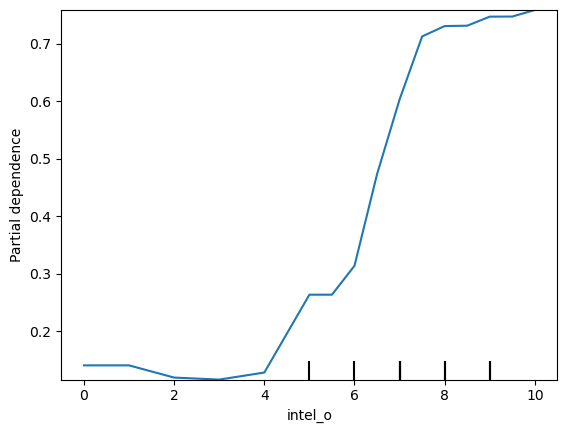

PyObject <sklearn.inspection._plot.partial_dependence.PartialDependenceDisplay object at 0x000000009453A940>

In [202]:
# THIS IS THE SCIKIT VERSION OF INTERPRETML
@sk_import inspection: plot_partial_dependence

using Pandas
py_xtrain = Pandas.DataFrame(X[1:ntrain,:])

plot_partial_dependence(trees, py_xtrain,[:intel_o])


In [203]:
# Redoing the models with only important features
X2 = just_attr[:, filter(col -> (col==:attr_o||col==:fun_o||col==:shar_o||col==:avg_attr_self||col==:avg_attr_others), selected)]

xtrain2 = convert(Matrix, X2[1:ntrain, :])
xtest2 = convert(Matrix, X2[ntrain+1:end, :]);

Training Set Error: 0.11211445559271646
Testing Set Error: 0.11783060921248142


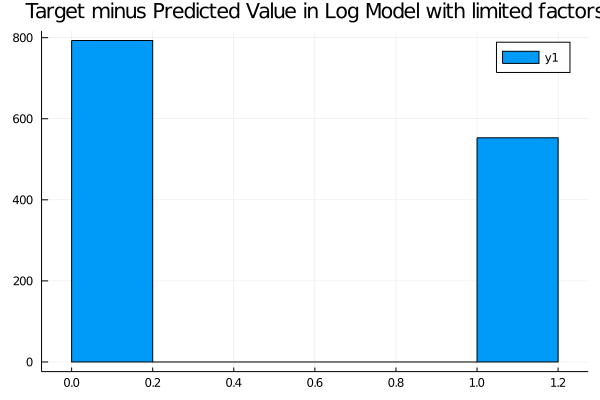

In [205]:
log_reg = fit!(LogisticRegression(penalty="none"), xtrain2, target[1:ntrain])
println("Training Set Error: ",sum(predict(log_reg,xtrain2).==target[1:ntrain])/length(xtrain2))
println("Testing Set Error: ",sum(predict(log_reg,xtest2).==target[ntrain+1:end])/length(xtest2))

histogram(target[ntrain+1:end].-predict(log_reg,xtest2), title="Target minus Predicted Value in Log Model with limited factors")

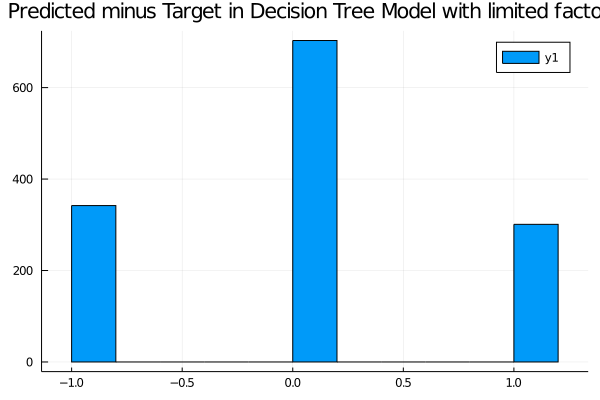

In [207]:
rf2 = RandomForestRegressor(random_state=69)

trees2 = fit!(rf2, xtrain2, target[1:ntrain])
predicted_dec2 = round.(predict(trees2, xtest2))

histogram(predicted_dec2.-target[ntrain+1:end], title="Predicted minus Target in Decision Tree Model with limited factors")

In [15]:
"""This function just computes the mean squared error."""
function MSE(y, pred)
    sqerr = (y .- pred)
    return mean(sqerr)
end

"""This completed function plots the main diagonal; 
for a "predicted vs true" plot with perfect predictions,
all data lies on this line"""
function plotDiagonal(xmin, xmax)
    xsamples = [xmin, xmax]
    plot!(xsamples, xsamples, color=:black)
end

"""This completed helper funciton plots x vs, y and labels the axes."""
function plotdata(x,y,xname, yname; margin=.05, plotDiag=true, zeromin=false)
    StatsPlots.scatter(x,y, label="data")
    xlabel!(xname)
    ylabel!(yname)
    range_y = maximum(y) - minimum(y)
    range_x = maximum(x) - minimum(x)
    if plotDiag
        plotDiagonal(minimum(x)-margin*range_x, maximum(x)+margin*range_x)
    end
    if zeromin
        ylims!((0.0,maximum(y)+margin*range_y))
        xlims!((0.0,maximum(x)+margin*range_x))
    else
        ylims!((minimum(y)-margin*range_y,maximum(y)+margin*range_y))
        xlims!((minimum(x)-margin*range_x,maximum(x)+margin*range_x))
    end
end

"""This completed function plots the predicted labels vs the actual labels
(We only plots the first 1000 points to avoid slow plots.)"""
function plot_pred_true(test_pred, test_y, max_points = 1000)
    plotdata(test_pred[1:max_points], test_y[1:max_points], "Predicted (\$)", "True (\$)", zeromin=true)
end

plot_pred_true

In [16]:
match_rate = just_attr |>
    @groupby(_.iid)|>
    @map({iid=key(_), rate=mean(_.dec_o)})|>
    DataFrame

match_rate = join(match_rate, just_attr, on="iid")
# Shuffle Data to ensure fair test/train split
match_rate = match_rate[shuffle(1:end), :]
#Making the split
train_proportion = 0.8
n = size(match_rate, 1)
ntrain = convert(Int, round(train_proportion*n))
println("Size of dataset: ", string(n))
println("Size of training set: ", string(ntrain))
println("Size of testing set: ", string(n-ntrain))


target = match_rate[:rate]
X = match_rate[:, filter(col -> (col==:avg_attr_others||col==:avg_attr_self), selected)]
X = hcat(X, ones(size(X,1)))
xtrain = convert(Matrix, X[1:ntrain, :])
xtest = convert(Matrix, X[ntrain+1:end, :]);

Size of dataset: 8084
Size of training set: 6467
Size of testing set: 1617


Train MSE	-5.845881310427684e-16
Test MSE 	-0.0020219456062671557


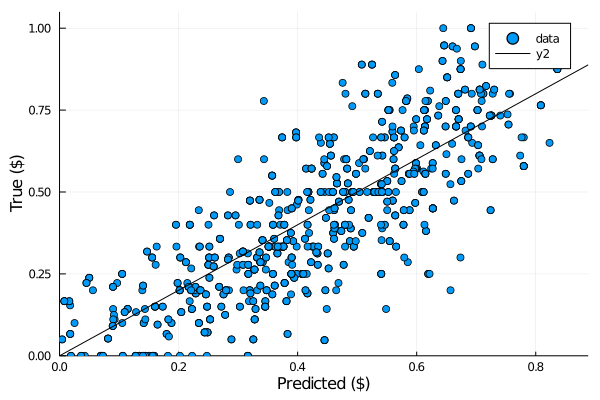

In [17]:
# The weights of your linear equation (compute via least squares)
w = xtrain\target[1:ntrain]

train_pred = [dot(w, xtrain[i,:]) for i in 1:size(xtrain,1)]
test_pred = [dot(w, xtest[i,:]) for i in 1:size(xtest,1)]

train_MSE = MSE(target[1:ntrain],train_pred)
test_MSE = MSE(target[ntrain+1:end],test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

plot_pred_true(test_pred,  target[ntrain+1:end])

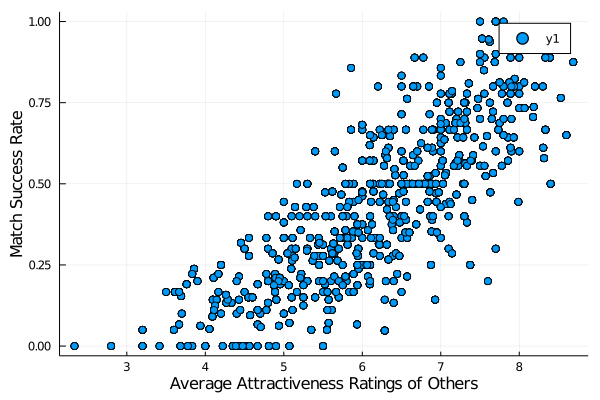

In [18]:
x1="Average Attractiveness Ratings of Others"
y1="Match Success Rate"
StatsPlots.scatter(match_rate[:avg_attr_others], match_rate[:rate], xlabel=x1, ylabel=y1)

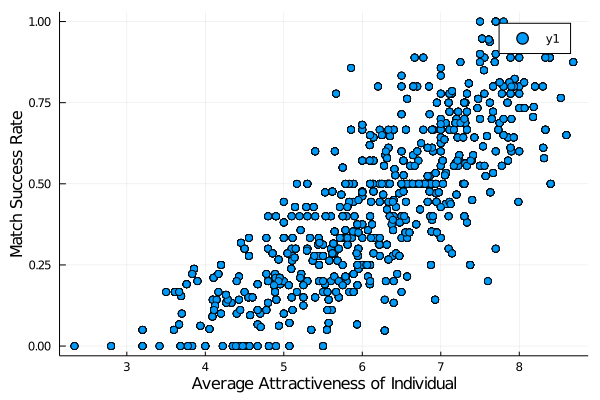

In [19]:
x1="Average Attractiveness of Individual"
y1="Match Success Rate"
StatsPlots.scatter(match_rate[:avg_attr_others], match_rate[:rate], xlabel=x1, ylabel=y1)